### Importing Packages

In [1]:
import pandas as pd
import re
import nltk
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn.ensemble  import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [2]:
messages = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
messages = messages.loc[:,['v1','v2']]
messages.columns = ["label", "message"]

messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Lemmatizing Data and appending in a list

In [3]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['message'][i])
    review = review.lower()
    review = review.split()
    
    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### Creating the Bag of Words model

In [4]:
cv = CountVectorizer(max_features=2500)
X_Bow = cv.fit_transform(corpus).toarray()
X_Bow = pd.DataFrame(X_Bow, columns = cv.get_feature_names() )
y_Bow = pd.get_dummies(messages['label'])
y_Bow = y_Bow.loc[:,['spam']]

### Creating the TFIDF of Words model

In [5]:
tv = TfidfVectorizer(max_features=2500)
X_TFIDF = tv.fit_transform(corpus).toarray()
X_TFIDF = pd.DataFrame(X_TFIDF, columns = tv.get_feature_names() )
y_TFIDF = pd.get_dummies(messages['label'])
y_TFIDF = y_TFIDF.loc[:,['spam']]

### Hyperparametertuning

In [6]:
def model_hyperparameter_tuning(X,y):
    model_params = {

        'Logistic_Regression' : {
            'model': LogisticRegression(solver='liblinear'),
            'params': {
                'C': list(range(1,5))
            }
         },  
        'naive_bayes_gaussian': {
           'model': GaussianNB(),
           'params': {}
         },
        'naive_bayes_multinomial': {
           'model': MultinomialNB(),
           'params': {}
         },
        'Random_Forest': {
            'model': RandomForestClassifier(),
            'params' : {
                'n_estimators': list(range(1,25))
            }
        },
        'Decision_Tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'criterion': ['gini','entropy'],  
                'splitter' : ['best','random'],
                'min_samples_leaf' : list(range(1,25))
            }
        },
        'SVM': {
            'model': svm.SVC(gamma='auto'),
            'params' : {
                'C': list(range(1,10)),
                'kernel': ['rbf','linear']
            }  
        },
        'XG_Boost': {
            'model': XGBClassifier(silent=True, verbosity = 0),
            'params': { 'n_estimators' :  [10, 50, 100, 130], 
                        'criterion': ['gini', 'entropy'], 
                        'max_depth': range(2, 10, 1) }
            }  
    }
    scores = []

    for model_name, mp in model_params.items():
        print('Running ' + model_name)
        clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
        clf.fit(X, y)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_,
            'best_estimators' : clf.best_estimator_
        })
    hyperparameter_tuning_results = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimators'])
    return hyperparameter_tuning_results

### Getting best model

In [7]:
BOW_Results = model_hyperparameter_tuning(X_Bow,y_Bow)
BOW_Results['Method'] = 'Bag of words'
BOW_Results

Running Logistic_Regression
Running naive_bayes_gaussian
Running naive_bayes_multinomial
Running Random_Forest
Running Decision_Tree
Running SVM
Running XG_Boost


,model,best_score,best_params,best_estimators,Method
0,Logistic_Regression,0.982771,{'C': 3},"LogisticRegression(C=3, solver='liblinear')",Bag of words
1,naive_bayes_gaussian,0.867732,{},GaussianNB(),Bag of words
2,naive_bayes_multinomial,0.981873,{},MultinomialNB(),Bag of words
3,Random_Forest,0.978463,{'n_estimators': 24},"(DecisionTreeClassifier(max_features='auto', r...",Bag of words
4,Decision_Tree,0.970207,"{'criterion': 'gini', 'min_samples_leaf': 2, '...","DecisionTreeClassifier(min_samples_leaf=2, spl...",Bag of words
5,SVM,0.983309,"{'C': 1, 'kernel': 'linear'}","SVC(C=1, gamma='auto', kernel='linear')",Bag of words
6,XG_Boost,0.980796,"{'criterion': 'gini', 'max_depth': 9, 'n_estim...","XGBClassifier(base_score=0.5, booster='gbtree'...",Bag of words


In [8]:
TFIDF_Results = model_hyperparameter_tuning(X_TFIDF,y_TFIDF) 
TFIDF_Results['Method'] = 'TFIDF'
TFIDF_Results

Running Logistic_Regression
Running naive_bayes_gaussian
Running naive_bayes_multinomial
Running Random_Forest
Running Decision_Tree
Running SVM
Running XG_Boost


,model,best_score,best_params,best_estimators,Method
0,Logistic_Regression,0.977207,{'C': 4},"LogisticRegression(C=4, solver='liblinear')",TFIDF
1,naive_bayes_gaussian,0.863604,{},GaussianNB(),TFIDF
2,naive_bayes_multinomial,0.978642,{},MultinomialNB(),TFIDF
3,Random_Forest,0.978822,{'n_estimators': 13},"(DecisionTreeClassifier(max_features='auto', r...",TFIDF
4,Decision_Tree,0.966978,"{'criterion': 'entropy', 'min_samples_leaf': 1...","DecisionTreeClassifier(criterion='entropy', sp...",TFIDF
5,SVM,0.983488,"{'C': 2, 'kernel': 'linear'}","SVC(C=2, gamma='auto', kernel='linear')",TFIDF
6,XG_Boost,0.978104,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...","XGBClassifier(base_score=0.5, booster='gbtree'...",TFIDF


In [9]:
Combined_results = pd.concat([BOW_Results,TFIDF_Results])
Combined_results.sort_values(by = 'best_score', inplace = True, ascending = False)
Combined_results = Combined_results.reset_index(drop = True)

best_estimator  = Combined_results.loc[0,'best_estimators']
method = Combined_results.loc[0,'Method']
print("Best Estimator : {}".format(best_estimator))
print("Best Method : {}".format(method))
Combined_results

Best Estimator : SVC(C=2, gamma='auto', kernel='linear')
Best Method : TFIDF


,model,best_score,best_params,best_estimators,Method
0,SVM,0.983488,"{'C': 2, 'kernel': 'linear'}","SVC(C=2, gamma='auto', kernel='linear')",TFIDF
1,SVM,0.983309,"{'C': 1, 'kernel': 'linear'}","SVC(C=1, gamma='auto', kernel='linear')",Bag of words
2,Logistic_Regression,0.982771,{'C': 3},"LogisticRegression(C=3, solver='liblinear')",Bag of words
3,naive_bayes_multinomial,0.981873,{},MultinomialNB(),Bag of words
4,XG_Boost,0.980796,"{'criterion': 'gini', 'max_depth': 9, 'n_estim...","XGBClassifier(base_score=0.5, booster='gbtree'...",Bag of words
5,Random_Forest,0.978822,{'n_estimators': 13},"(DecisionTreeClassifier(max_features='auto', r...",TFIDF
6,naive_bayes_multinomial,0.978642,{},MultinomialNB(),TFIDF
7,Random_Forest,0.978463,{'n_estimators': 24},"(DecisionTreeClassifier(max_features='auto', r...",Bag of words
8,XG_Boost,0.978104,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...","XGBClassifier(base_score=0.5, booster='gbtree'...",TFIDF
9,Logistic_Regression,0.977207,{'C': 4},"LogisticRegression(C=4, solver='liblinear')",TFIDF


Here we can see that the best estimator turns out to be SVM on a dataset that uses TFIDF method.

### Train Test Split

In [10]:
if method == 'TFIDF':
    X_train,X_test,y_train,y_test = train_test_split(X_TFIDF, y_TFIDF, test_size=0.33, random_state=42)
else:
    X_train,X_test,y_train,y_test = train_test_split(X_Bow, y_Bow, test_size=0.33, random_state=42)

### Using best estimater on data

In [11]:
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

if len(y_test['spam'].unique()) == 1:
    score = accuracy_score(y_test, y_pred)
else:
    score = roc_auc_score(y_test, y_pred) 

print('Accuracy : {}'.format(score))

Accuracy : 0.9448532721217031


### Confusion Matrix

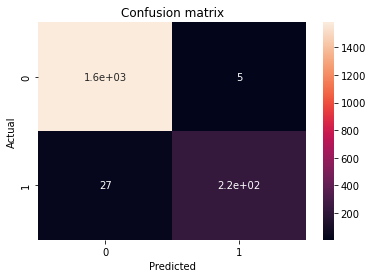

In [13]:
cm = confusion_matrix(y_test,y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual'); 
ax.set_title('Confusion matrix'); 